In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import pickle

In [14]:
# load dataframe
df = pd.read_csv("../results/cases_train_processed.csv")
df

,age,sex,province,country,latitude,longitude,date_confirmation,additional_information,source,outcome,Confirmed,Deaths,Recovered,Active,Incidence_Rate,Case-Fatality_Ratio
0,-1,unknown,Delhi,India,28.614740,77.209100,26.05.2020,none,https://twitter.com/CMODelhi/status/1265203060...,recovered,238828.0,4907.0,201671.0,32250.0,1276.409575,2.054617
1,-1,unknown,Uttar Pradesh,India,25.436090,81.847180,20.05.2020,none,https://t.me/indiacovid/5222,hospitalized,342788.0,4869.0,270094.0,67825.0,144.099577,1.420411
2,-1,unknown,Maharashtra,India,18.504220,73.853020,26.05.2020,none,https://t.me/indiacovid/5601,hospitalized,1167496.0,31791.0,834432.0,301273.0,948.072083,2.723007
3,15,female,Baden-Wurttemberg,Germany,48.120860,7.849500,15.03.2020,none,unknown,nonhospitalized,46779.0,1871.0,41228.0,3680.0,422.592353,3.999658
4,-1,unknown,Gujarat,India,23.188409,73.647122,20.05.2020,none,https://twitter.com/PIBAhmedabad/status/126311...,hospitalized,120336.0,3286.0,100974.0,16076.0,188.400627,2.730687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335148,-1,unknown,Tamil Nadu,India,13.083620,80.282520,29.05.2020,none,https://stopcorona.tn.gov.in/wp-content/upload...,recovered,530908.0,8685.0,475717.0,46506.0,682.039258,1.635877
335149,15,male,Santa Fe,Argentina,-32.967800,-60.659240,31.03.2020,none,unknown,nonhospitalized,622934.0,12799.0,478077.0,132058.0,1378.301340,2.054632
335150,-1,unknown,Delhi,India,28.614740,77.209100,16.04.2020,none,https://twitter.com/ANI/status/125082767765900...,hospitalized,238828.0,4907.0,201671.0,32250.0,1276.409575,2.054617
335151,-1,unknown,Maharashtra,India,19.200000,72.966670,30.05.2020,none,https://arogya.maharashtra.gov.in/pdf/ncovidep...,hospitalized,1167496.0,31791.0,834432.0,301273.0,948.072083,2.723007


In [15]:
#Make outcome numeric

df['outcome'] = df.outcome.astype('category')
outcomes = dict(enumerate(df.outcome.cat.categories))
print (outcomes)

df['outcome'] = df.outcome.cat.codes

{0: 'deceased', 1: 'hospitalized', 2: 'nonhospitalized', 3: 'recovered'}


In [16]:
#Divide into y and X
y = df.outcome
X = df.drop(['outcome', 'province', 'country', 'latitude', 'longitude', 'additional_information', 'source','Confirmed'], axis = 'columns')
X = pd.get_dummies(X)

In [17]:
#Split the train dataset further into train dataset and validation dataset
msk = np.random.rand(len(df)) < 0.8

train_X = X[msk]
train_y = y[msk]
validate_X = X[~msk]
validate_y = y[~msk]

print(len(train_X))
print(len(train_y))

print(len(validate_X))
print(len(validate_y))

268203
268203
66950
66950


In [18]:
# Build RandomForests Model
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(train_X, train_y)

RandomForestClassifier(random_state=0)

In [19]:
filename = 'rf_classifier.pkl'
pickle.dump(rf, open(filename, 'wb'))

In [20]:
rf.score(train_X, train_y)

0.8273173678146777

In [21]:
rf.score(validate_X, validate_y)

0.82067214339059

In [22]:
train_predicted = rf.predict(train_X)
validate_predicted = rf.predict(validate_X)

[[  627  2170    61   729]
 [    2 85431     0 11818]
 [   26     1 96433   312]
 [   53 30888   254 39398]]


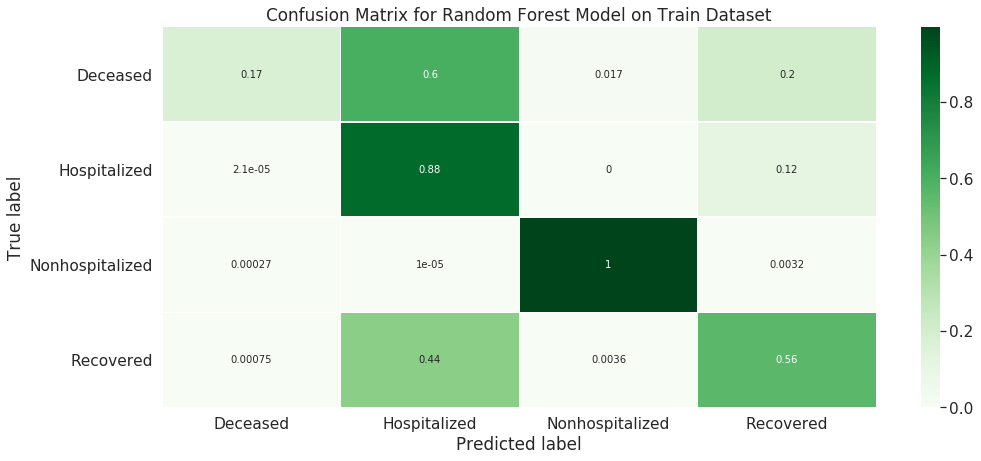

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get and reshape confusion matrix data
matrix = confusion_matrix(train_y, train_predicted)
print(matrix)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Deceased', 'Hospitalized', 'Nonhospitalized', 
               'Recovered']
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model on Train Dataset')
plt.savefig("../plots/rf_train_cm.png")

[[   59   571    53   226]
 [   11 21215     1  3049]
 [   40     2 24014   224]
 [   42  7585   202  9656]]


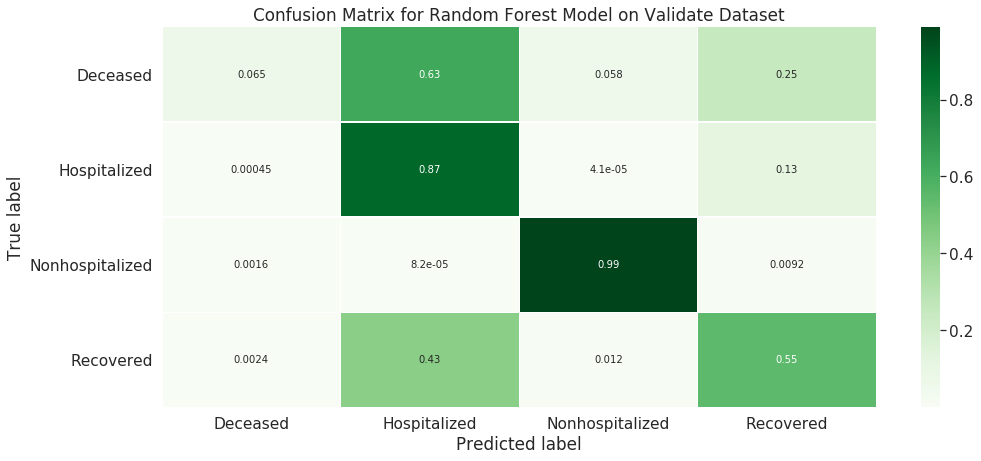

In [25]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(validate_y, validate_predicted)
print(matrix)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Deceased', 'Hospitalized', 'Nonhospitalized', 
               'Recovered']
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model on Validate Dataset')
plt.savefig("../plots/rf_validate_cm.png")

In [26]:
from sklearn.metrics import classification_report

print(classification_report(train_y, train_predicted))
print(classification_report(validate_y, validate_predicted))

              precision    recall  f1-score   support

           0       0.89      0.17      0.29      3587
           1       0.72      0.88      0.79     97251
           2       1.00      1.00      1.00     96772
           3       0.75      0.56      0.64     70593

    accuracy                           0.83    268203
   macro avg       0.84      0.65      0.68    268203
weighted avg       0.83      0.83      0.82    268203

              precision    recall  f1-score   support

           0       0.39      0.06      0.11       909
           1       0.72      0.87      0.79     24276
           2       0.99      0.99      0.99     24280
           3       0.73      0.55      0.63     17485

    accuracy                           0.82     66950
   macro avg       0.71      0.62      0.63     66950
weighted avg       0.82      0.82      0.81     66950



In [74]:
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc

def plotROC(n_classes, y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
    for i in range(n_classes):
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()

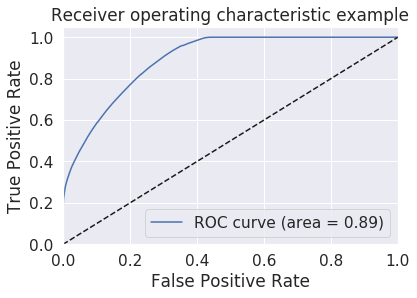

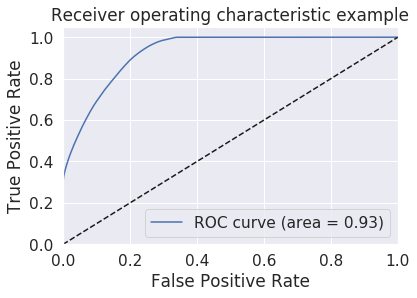

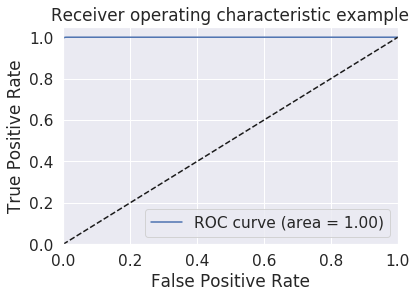

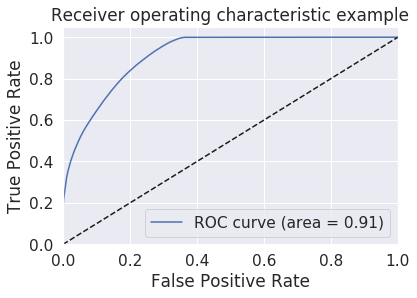

In [75]:
#ROC for train

y_score = rf.predict_proba(train_X)
lb = preprocessing.LabelBinarizer()
lb.fit(train_y.values.flatten())
NEWy_test = lb.transform(train_y.values.flatten())

plotROC(4, NEWy_test, y_score)

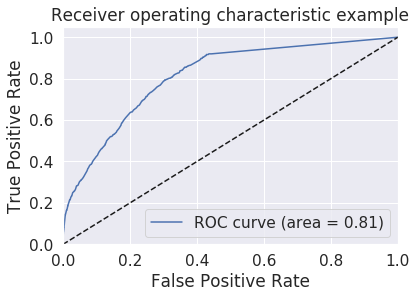

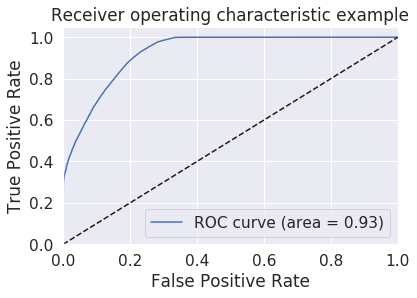

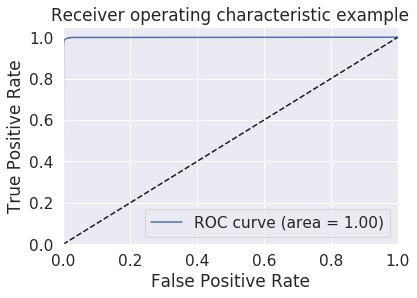

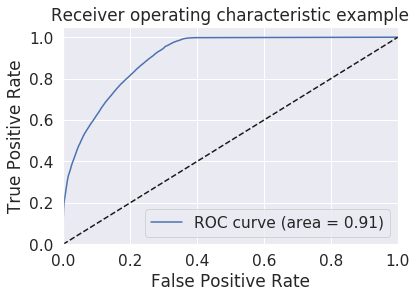

In [76]:
#ROC for train

y_score = rf.predict_proba(validate_X)
lb = preprocessing.LabelBinarizer()
lb.fit(validate_y.values.flatten())
NEWy_test = lb.transform(validate_y.values.flatten())

plotROC(4, NEWy_test, y_score)